In [2]:
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.applications import Xception,VGG19,ResNet50,InceptionResNetV2,ResNet152V2,EfficientNetB2,ConvNeXtTiny
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

random.seed(555)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Dataset


LOADING THE DATASET

In [5]:
# Base path for your dataset
###base_path1 = 'archive/casting_data/casting_data/'
base_path = '/content/drive/MyDrive/Dataset/archive/casting_data/casting_data/'

# Define the training and test paths
dir_train = base_path + 'train'
dir_test = base_path + 'test'

# Train
dir_train_def = dir_train + '/def_front/'
dir_train_ok = dir_train + '/ok_front/'
# Test
dir_test_def = dir_test + '/def_front/'
dir_test_ok = dir_test + '/ok_front/'

In [6]:
image_files_train_def = os.listdir(dir_train_def)
image_files_train_ok = os.listdir(dir_train_ok)

image_files_test_def = os.listdir(dir_test_def)
image_files_test_ok = os.listdir(dir_test_ok)

n = len(image_files_train_def)
m = len(image_files_train_ok)
print(f'the number of all the images in the training set is {n+m}')
print(f'number of def imgs is {n}')
print(f'number of ok imgs is {m}')
print(f'the ratio between ok and def imgs is {m/n}')

the number of all the images in the training set is 6643
number of def imgs is 3768
number of ok imgs is 2875
the ratio between ok and def imgs is 0.763004246284501


UNDERSTANDING THE DATASET

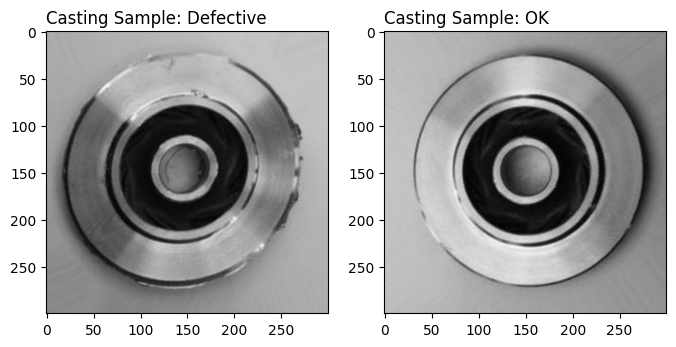

In [7]:
# Plot samples of defective and non-defective casting
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sample_def = plt.imread(dir_train_def+ image_files_train_def[0])
sample_ok = plt.imread(dir_train_ok + image_files_train_ok[0])
axes[0].imshow(sample_def)
axes[1].imshow(sample_ok)
axes[0].set_title('Casting Sample: Defective', loc='left')
axes[1].set_title('Casting Sample: OK', loc='left')
axes[0].grid(False)
axes[1].grid(False)
plt.show()

CHECKING FOR CLASS IMBALANCES TO ENSURE UNBIASED MODELLING

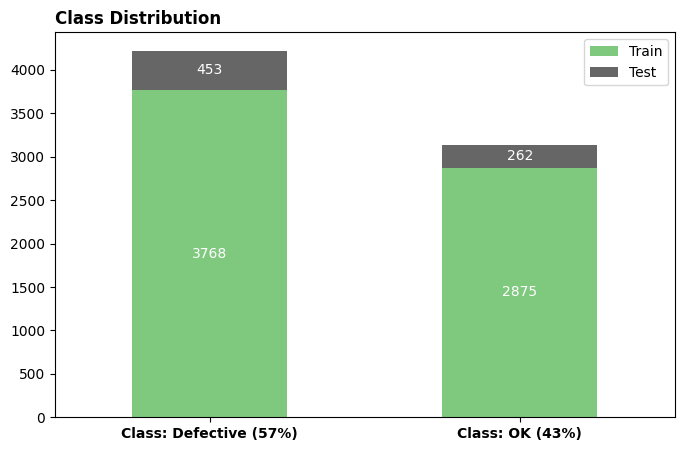

In [8]:
n_train = [len(image_files_train_def), len(image_files_train_ok)]
n_test = [len( image_files_test_def), len( image_files_test_ok)]


dist_df = pd.DataFrame(
    data=[n_train, n_test],
    columns=['Defective', 'OK'],
    index=['Train', 'Test'])

# Visualize class distribution
ax = dist_df.T.plot(kind='bar', stacked=True, rot=0, figsize=(8,5), colormap='Accent')
ax.set_title('Class Distribution', loc='left', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25,
            bar.get_y()+bar.get_height()/2,
            int(bar.get_height()),
            ha='center', va='center', color='white')
pct_def = 100*dist_df['Defective'].values.sum()/dist_df.values.sum()
pct_ok = 100-pct_def
ax.set_xticklabels([f'Class: Defective ({pct_def:.0f}%)',
                    f'Class: OK ({pct_ok:.0f}%)'], weight='bold')
plt.show()

In [9]:
# same for the ok_front
def get_image_info(image_path):
    with Image.open(image_path) as img:
        size = img.size
        mode = img.mode
    return size, mode

# Example usage:
for image_file in image_files_train_def:
    image_path = os.path.join(dir_train_def, image_file)
    size, mode = get_image_info(image_path)
    print(f"Image: {image_file}, Size: {size}, Mode: {mode}")
    break

Image: cast_def_0_6787.jpeg, Size: (300, 300), Mode: RGB


PRE-PROCESSING


In [10]:
# We can observe that we can generate more examples just using rotations
img_size = (300,300)
rand_seed = 555
batch_size = 32
epochs = 15

In [11]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    brightness_range=[0.2, 1.5],
    validation_split=0.2,
)

test_gen = ImageDataGenerator(rescale=1./255)

In [12]:
arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}

arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

# 80%
train_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='training',
                                          **arg_train)
#20%
valid_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='validation',
                                          **arg_train)

# for the 0 and 1 ...etc
test_set = test_gen.flow_from_directory(directory=dir_test,
                                        **arg_test)

Found 5315 images belonging to 2 classes.
Found 1328 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [13]:
train_set.class_indices

{'ok_front': 0, 'def_front': 1}

DEFINE FUNCTION FOR PIPELINE THAT WOULD DO ALL THE PREPROCESSING

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_pipeline(base_path, img_size=(300, 300), batch_size=32, rand_seed=555):

    #LOADING THE DATASET
    dir_train = base_path + 'train'
    dir_test = base_path + 'test'

    # Train
    dir_train_def = dir_train + '/def_front/'
    dir_train_ok = dir_train + '/ok_front/'
    # Test
    dir_test_def = dir_test + '/def_front/'
    dir_test_ok = dir_test + '/ok_front/'


    # ImageDataGenerator for data preprocessing and augmentation
    train_gen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=40,
        brightness_range=[0.2, 1.5],
        validation_split=0.2,
        fill_mode = 'nearest'
    )

    test_gen = ImageDataGenerator(rescale=1./255)

    # Arguments for flow_from_directory
    arg_train = {
        'target_size': img_size,
        'color_mode': 'rgb',
        'class_mode': 'binary',
        'batch_size': batch_size,
        'seed': rand_seed,
        'shuffle': True,
        'subset': 'training'
    }

    arg_valid = {
        'target_size': img_size,
        'color_mode': 'rgb',
        'class_mode': 'binary',
        'batch_size': batch_size,
        'seed': rand_seed,
        'shuffle': True,
        'subset': 'validation'
    }

    arg_test = {
        'target_size': img_size,
        'color_mode': 'rgb',
        'class_mode': 'binary',
        'batch_size': batch_size,
        'seed': rand_seed,
        'shuffle': False
    }

    # Create data generators
    train_set = train_gen.flow_from_directory(directory=dir_train, **arg_train)
    valid_set = train_gen.flow_from_directory(directory=dir_train, **arg_valid)
    test_set = test_gen.flow_from_directory(directory=dir_test, **arg_test)

    return train_set, valid_set, test_set


In [15]:
# Replace 'your_dataset_path' with the actual path to your dataset
dataset_path = 'archive/casting_data/casting_data/'
train_set, valid_set, test_set = preprocess_pipeline(dataset_path)


Found 5315 images belonging to 2 classes.
Found 1328 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [16]:
print(train_set)

In [17]:
train_set

In [18]:
train_set_shape = train_set.image_shape
print("Shape of the training set:", train_set_shape)

Shape of the training set: (300, 300, 3)


In [19]:
## Model Training

## Model Training

In [20]:
# Function to load a pre-trained ResNet152V2 model
def load_pretrained_model(model_name):
  return ResNet152V2(weights='imagenet', include_top=False)

# Function to create and compile a new model based on a pre-trained base model
def create_and_compile_model(base_model, learning_rate=0.01):
  # Define the architecture of the new model
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer='l1_l2')(x)
    x = Dense(128, activation='relu', kernel_regularizer='l1_l2')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Changed the number of output neurons and activation

    model = Model(inputs=base_model.input, outputs=predictions)


     # Freeze the layers of the pre-trained base model
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with specified optimizer, loss function, and metrics
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss='binary_crossentropy',  # Changed the loss function
                  metrics=['accuracy', AUC(), Precision(), Recall()])  # Updated metrics

    return model

def train_and_evaluate_model(model, model_name, train_set, valid_set, test_set, epochs=10, batch_size=32):
  # Configure model checkpoint to save the best model based on validation AUC
    model_checkpoint = ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_auc',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )

    # Start the timer
    start_time = time.time()

    # Train the model and store the training history
    history = model.fit(
        train_set,
        steps_per_epoch=train_set.samples // batch_size,
        epochs=epochs,
        validation_data=valid_set,
        validation_steps=valid_set.samples // batch_size,
        callbacks=[model_checkpoint]
    )

    # End the timer
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model on the test set
    test_loss, *test_metrics = model.evaluate(test_set, steps=test_set.samples // batch_size)
    test_acc = test_metrics[0]
    test_auc = test_metrics[1]
    test_precision = test_metrics[2]
    test_recall = test_metrics[3]

    # Start the evaluation timer
    evaluation_time = time.time() - end_time

    # Print the results
    print(f"model: {model_name}")
    print(f"Test accuracy: {test_acc * 100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Evaluation time: {evaluation_time:.2f} seconds")

    # Calculate additional evaluation metrics
    y_true = test_set.classes
    y_pred = model.predict(test_set)
    y_pred_classes = (y_pred > 0.5).astype(int)  # Convert to 0 or 1 based on a threshold
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes)
    auc = roc_auc_score(y_true, y_pred)

    return test_acc, cm, report, auc, test_precision, test_recall, history.history

In [21]:
%%time
model_name = 'ResNet152V2'
results = {}

print(f"Training model: {model_name}")
# Load a pre-trained ResNet152V2 model
base_model = load_pretrained_model(model_name)
# Create and compile a new model based on the pre-trained ResNet152V2
model = create_and_compile_model(base_model)

# Train and evaluate the model, obtaining various metrics
test_acc, cm, report, auc, precision, recall, history = train_and_evaluate_model(model,
                                                      model_name,
                                                      train_set,
                                                      valid_set,
                                                      test_set,
                                                      epochs,
                                                      batch_size)

# Store the results in a dictionary for later analysis or comparison
results[model_name] = {
    'test_accuracy': test_acc,
    'confusion_matrix': cm,
    'classification_report': report,
    'roc_auc': auc,
    'history': history
}

Training model: ResNet152V2
234545216/234545216 [==============================] - 1s 0us/step


Epoch 1/15
166/166 [==============================] - ETA: 0s - loss: 36.2386 - accuracy: 0.9249 - auc: 0.9692 - precision: 0.9082 - recall: 0.9189
Epoch 1: val_auc improved from -inf to 0.99612, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 958s 6s/step - loss: 36.2386 - accuracy: 0.9249 - auc: 0.9692 - precision: 0.9082 - recall: 0.9189 - val_loss: 6.1632 - val_accuracy: 0.9840 - val_auc: 0.9961 - val_precision: 0.9740 - val_recall: 0.9895
Epoch 2/15
166/166 [==============================] - ETA: 0s - loss: 3.8843 - accuracy: 0.9468 - auc: 0.9864 - precision: 0.9317 - recall: 0.9467
Epoch 2: val_auc did not improve from 0.99612
166/166 [==============================] - 225s 1s/step - loss: 3.8843 - accuracy: 0.9468 - auc: 0.9864 - precision: 0.9317 - recall: 0.9467 - val_loss: 2.7713 - val_accuracy: 0.7866 - val_auc: 0.9952 - val_precision: 0.9932 - val_recall: 0.5106
Epoch 3/15
166/166 [==============================] - ETA: 0s - loss: 1.9822 - accuracy: 0.9567 - auc: 0.9911 - precision: 0.9363 - recall: 0.9654
Epoch 3: val_auc did not improve from 0.99612
166/166 [==============================] - 264s 2s/step - loss: 1.9822 - accuracy: 0.9567 - auc: 0.9911 - precision: 0.93

Best Model: ResNet152V2
Test Accuracy: 99.72%
Confusion Matrix:
[[451   2]
 [  0 262]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       453
           1       0.99      1.00      1.00       262

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715

ROC AUC: 1.00


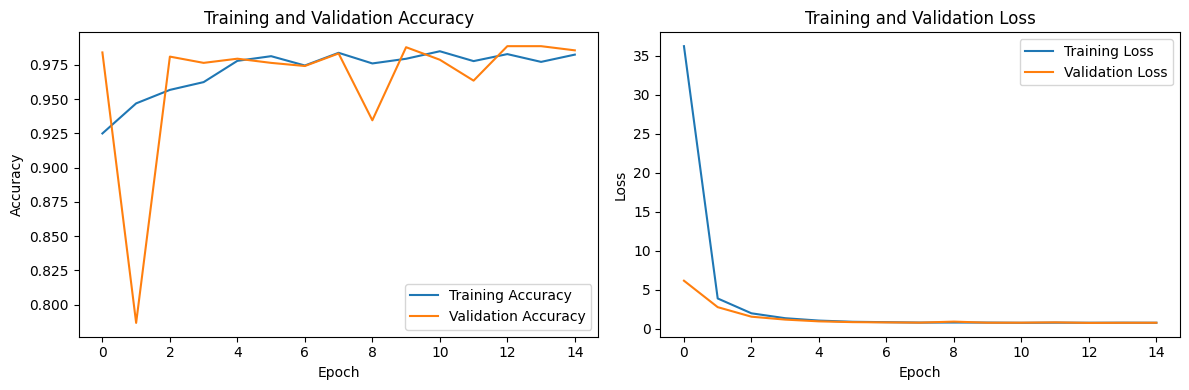

In [22]:
# Find the model with the highest test auc
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model_results = results[best_model_name]

# Access the performance metrics
best_test_acc = best_model_results['test_accuracy']
best_cm = best_model_results['confusion_matrix']
best_report = best_model_results['classification_report']
best_auc = best_model_results['roc_auc']
best_history = best_model_results['history']

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_test_acc * 100:.2f}%")
print("Confusion Matrix:")
print(best_cm)
print("Classification Report:")
print(best_report)
print(f"ROC AUC: {best_auc:.2f}")

# Plot training and validation accuracy and loss

plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Load the saved model
best_model = load_model("/content/drive/MyDrive/Dataset/best_model.h5")
# Assuming you have set up the 'test_set' as mentioned earlier
predictions = best_model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_set.classes

# Calculate classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
conf_matrix = confusion_matrix(true_labels, predicted_labels)

23/23 [==============================] - 13s 384ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       453
           1       0.97      1.00      0.98       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



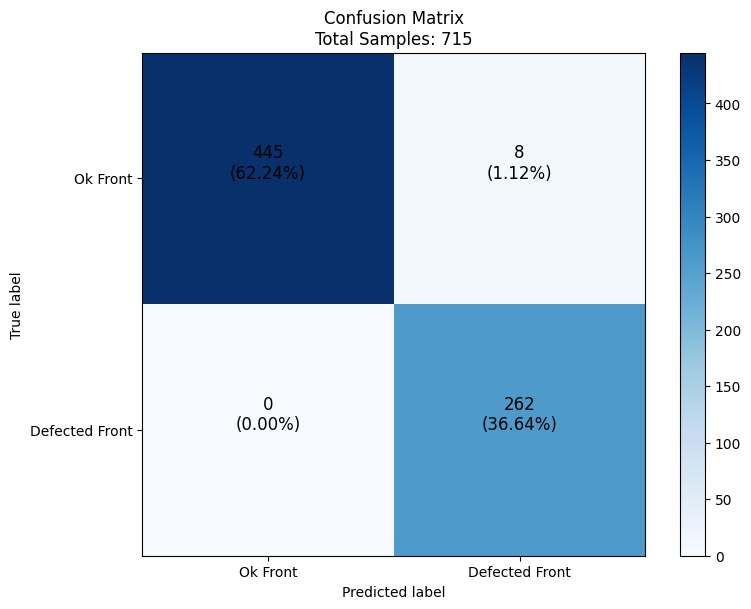

In [26]:
# Assuming you have 'conf_matrix' calculated as the confusion matrix
total_samples = np.sum(conf_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title(f'Confusion Matrix\nTotal Samples: {total_samples}')
plt.colorbar()
tick_marks = np.arange(2)  # Assuming you have 2 classes (0 and 1)
plt.xticks(tick_marks, ['Ok Front', 'Defected Front'])
plt.yticks(tick_marks, ['Ok Front', 'Defected Front'])
plt.tight_layout()

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add numbers inside the boxes with black color and percentages
for i in range(2):
    for j in range(2):
        count = conf_matrix[i, j]
        percentage = (count / total_samples) * 100
        plt.text(j, i, f'{count}\n({percentage:.2f}%)', horizontalalignment='center', color='black', fontsize=12)

plt.show()

## Results Visualization

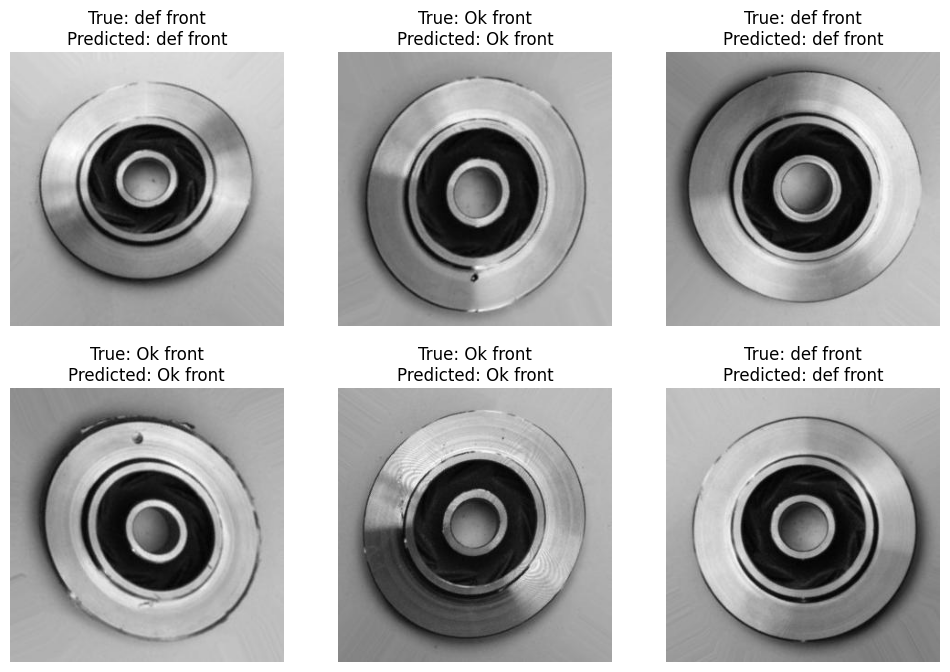

In [27]:
num_samples_to_display = 6
nbr_samples_every_row = 3
rows = num_samples_to_display // nbr_samples_every_row
random.seed(33)

total_samples = len(test_set.filenames)

# Generate random indices to select random samples
random_indices = random.sample(range(total_samples), num_samples_to_display)

# Initialize a list to store the selected images, true labels, and predicted labels
random_sample_data = []

# Extract the random images, true labels, and predicted labels
for idx in random_indices:
    image_path = test_set.filepaths[idx]
    true_label = test_set.classes[idx]
    image = plt.imread(image_path)
    predicted_label = predicted_labels[idx]
    true_label_text = "def front" if true_label == 1 else "Ok front"
    predicted_label_text = "def front" if predicted_label == 1 else "Ok front"
    random_sample_data.append((image, true_label_text, predicted_label_text))

# Visualize the random sample images with true and predicted labels
plt.figure(figsize=(12, 8))
for i, (image, true_label_text, predicted_label_text) in enumerate(random_sample_data):
    plt.subplot(rows, nbr_samples_every_row, i + 1)
    plt.imshow(image)
    plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}')
    plt.axis('off')
plt.show()

In [30]:
from google.colab import files
import pickle

file_path = '/content/drive/MyDrive/best_model.pkl'

with open(file_path, 'wb') as f:
    pickle.dump(best_model, f)

